In [1]:
import math
from ast import literal_eval

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.subplots as sp
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.parametrize as parametrize
from matrepr import mdisplay
from plotly.subplots import make_subplots
from rich import print as rprint
from torch import linalg
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from koopmann import aesthetics
from koopmann.data import (
    DatasetConfig,
    create_data_loader,
    get_dataset_class,
)
from koopmann.models import (
    MLP,
    Autoencoder,
    ExponentialKoopmanAutencoder,
    LowRankKoopmanAutoencoder,
)
from koopmann.models.utils import get_device
from koopmann.visualization import plot_eigenvalues

%load_ext autoreload
%autoreload 2

In [2]:
from analysis.common import compare_model_autoencoder_acc, shrink_eigenvalues

In [3]:
task = "mnist"
scale_idx = "0"
k = "1"
dim = "1024"

# flavor = "exponential"
# flavor = "standard"
flavor = "lowrank_20"

user = "nsa325"

model_name = f"{task}_probed"
ae_name = f"{task}_model"


Load and prepare MLP

In [4]:
# Original model path
model_file_path = f"/scratch/{user}/koopmann_model_saves/{model_name}.safetensors"

model, model_metadata = MLP.load_model(model_file_path)

model.modules[-2].remove_nonlinearity()
# model.modules[-3].update_nonlinearity("leakyrelu")
model.modules[-3].remove_nonlinearity()

model.eval().hook_model()

Build data

In [5]:
dataset_config = DatasetConfig(
    dataset_name=model_metadata["dataset"], num_samples=5_000, split="test", seed=21
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
dataset = DatasetClass(config=dataset_config)

# Raw images and labels
raw_images, labels = dataset.data, dataset.labels

# Processed for MLP
mlp_transform = transforms.Compose(
    [
        transforms.Lambda(lambda x: x / 255),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
mlp_inputs = mlp_transform(raw_images)

# Processed for AE
ae_transform = transforms.Compose(
    [
        transforms.Lambda(lambda x: x / 255),
        transforms.Lambda(lambda x: x * 2 - 1),
    ]
)
ae_inputs = ae_transform(raw_images)

Build autoencoder

In [6]:
# Autoenoder path in work dir
ae_file_path = f"/scratch/{user}/koopmann_model_saves/scaling/dim_{dim}_k_{k}_loc_{scale_idx}_{flavor}_autoencoder_{ae_name}.safetensors"

# Choose model based on flag
if "standard" in flavor:
    AutoencoderClass = Autoencoder
elif "lowrank" in flavor:
    AutoencoderClass = LowRankKoopmanAutoencoder
elif "exponential" in flavor:
    AutoencoderClass = ExponentialKoopmanAutencoder

autoencoder, ae_metadata = AutoencoderClass.load_model(
    ae_file_path,
    strict=True,
    remove_param=True,
)
_ = autoencoder.eval()

(<Figure size 400x400 with 1 Axes>,
 array([<Axes: title={'center': '$k=1$, $dim=1024$'}>], dtype=object))

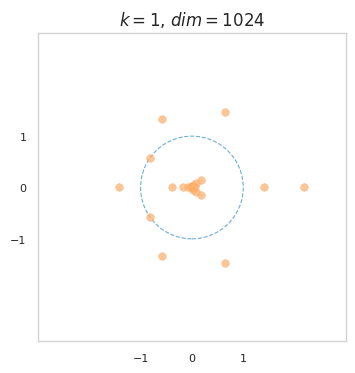

In [7]:
K_matrix = autoencoder.koopman_matrix.linear_layer.weight.T.detach()
k = literal_eval(ae_metadata["num_scaled"])

eigenvalues, eigenvectors = torch.linalg.eig(K_matrix)
plot_eigenvalues({(k, dim): eigenvalues}, axis=[-3, 3])

In [8]:
acc_mlp, acc_koopman = compare_model_autoencoder_acc(
    model, autoencoder, k, len(dataset.classes), mlp_inputs, ae_inputs, labels
)
mdisplay(acc_mlp, title="Original Model Testing Accuracy")
mdisplay(acc_koopman, title="Autoencoder Prediction Testing Accuracy")

/home/nsa325/work/koopmann/.venv/lib/python3.11/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:230.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


0,1,2,3,4,5,6,7,8,9
0.9918,0.9894,0.9700,0.9792,0.9817,0.9731,0.9833,0.9708,0.9692,0.9613


0,1,2,3,4,5,6,7,8,9
0.9888,0.9877,0.9729,0.9683,0.9623,0.9675,0.9739,0.9767,0.9805,0.9653
